# Preliminaries

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dependencies

### Import Dependencies

In [ ]:
%pip install -r requirements.txt

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, lr_scheduler
import torchvision.transforms as T
from torchvision import datasets, ops
from torchvision.models.feature_extraction import create_feature_extractor
from transformers import DetrFeatureExtractor
from einops import rearrange

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment
from pycocotools.coco import COCO

### Pull the COCO Dataset


#### Downloading the COCO 2017 Training and Validation Annotations


In [ ]:
%wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
%unzip -d ./ annotations_trainval2017.zip

#### Downloading the COCO 2017 Training Dataset

In [ ]:
%wget http://images.cocodataset.org/zips/train2017.zip
%unzip -d ./ train2017.zip

#### Downloading the COCO 2017 Validation Dataset

In [ ]:
%wget http://images.cocodataset.org/zips/val2017.zip
%unzip -d ./ val2017.zip

# Pre-Process

### Data Transformation and Visualization Tools


In [ ]:
# Classes for COCO Dataset
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush', 'empty'
]

# Colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098],
          [0.929, 0.694, 0.125], [0.494, 0.184, 0.556],
          [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
COLORS *= 100

revert_normalization = T.Normalize(
    mean=[-.485/.229, -.456/.224, -.406/.225],
    std=[1/.229, 1/.224, 1/.225]
)

def plot_im_with_boxes(im, boxes, probs=None, ax=None):
    """
    This Function takes in an image and bounding box coordinates
    and adds those bounding boxes to the image.
    """
    if ax is None:
        plt.imshow(im)
        ax = plt.gca()

    for i, b in enumerate(boxes.tolist()):
        xmin, ymin, xmax, ymax = b

        patch = plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            fill=False, color=COLORS[i], linewidth=2)

        ax.add_patch(patch)
        if probs is not None:
            if probs.ndim == 1:
                cl = probs[i].item()
                text = f'{CLASSES[cl]}'
            else:
                cl = probs[i].argmax().item()
                text = f'{CLASSES[cl]}: {probs[i,cl]:0.2f}'
        else:
            text = ''

        ax.text(xmin, ymin, text, fontsize=7,
                bbox=dict(facecolor='yellow', alpha=0.5))


def preprocess_annotations(anno, im_w, im_h):
    """
    This function filters out crowded data, in accordance with
    the COCO annotations. It also converts the bounding boxes from COCO to DETR
    format and scales them so they can be inputted into the DETR model.
    It then returns the classes and boxes of the images.
    """
    anno = [obj for obj in anno
            if 'iscrowd' not in obj or obj['iscrowd'] == 0]

    boxes = [obj["bbox"] for obj in anno]
    boxes = torch.as_tensor(
        boxes, dtype=torch.float32).reshape(-1, 4)

    boxes[:, 2:] += boxes[:, :2]
    boxes[:, 0::2].clamp_(min=0, max=im_w)
    boxes[:, 1::2].clamp_(min=0, max=im_h)
    keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
    boxes = boxes[keep]

    classes = [obj["category_id"] for obj in anno]
    classes = torch.tensor(classes, dtype=torch.int64)
    classes = classes[keep]

    # scales boxes to [0,1]
    boxes[:, 0::2] /= im_w
    boxes[:, 1::2] /= im_h
    boxes.clamp_(min=0, max=1)

    # Conveting bounding boxes to DETR format
    boxes = ops.box_convert(boxes, in_fmt='xyxy', out_fmt='cxcywh')

    return classes, boxes

class DETRCocoDetection(datasets.CocoDetection):
    """
    This Class Pre-processes all of the images in a
    COCO dataset(either training or validation) so that they are in a format
    that can be inputted into the DETR model.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge = 480

        self.T = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[.485, .456, .406],
                        std=[.229, .224, .225]),
            T.Resize((self.edge, self.edge), antialias=True)
        ])

        self.T_target = preprocess_annotations

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        w, h = img.size

        input_imgs = self.T(img)
        classes, boxes = self.T_target(target, w, h)

        return input_imgs, (classes, boxes)


def collate_fn(inputs):
    """
    This function is used to properly batch data in the Dataloader
    """
    input_imgs = torch.stack([i[0] for i in inputs])
    classes = tuple([i[1][0] for i in inputs])
    boxes = tuple([i[1][1] for i in inputs])
    return input_imgs, (classes, boxes)


# Architecture

### Main DETR Module

In [ ]:
"""
This factory function is used to get the outputs of the intermediate layers
for use in the loss function calculation of DETR.
"""
def get_inter_out(outs, name):
    def inter_out(self, input, output):
        outs[name] = output
    return inter_out


class DETR(nn.Module):
    """
    Implementation of DETR model with ResNet50 backbone,
    1x1 convolutional layer to convert dimensions, and then
    a 6 layer transformer encoder and decoder, with learned positonal
    embeddings, and two linear layers for class and bounding box
    predictions.
    """
    def __init__(
        self, d_model=256, n_classes=92, n_tokens=225,
        n_layers=6, n_heads=8, n_queries=100
    ):
        super().__init__()

        self.backbone = create_feature_extractor(
            torch.hub.load('pytorch/vision:v0.10.0',
                           'resnet50', pretrained=True),
            return_nodes={'layer4': 'layer4'}
        )

        self.conv1x1 = nn.Conv2d(
            2048, d_model, kernel_size=1, stride=1)

        self.pos_encoder = nn.Parameter(
            torch.rand((1, n_tokens, d_model)),
            requires_grad=True)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=4*d_model, dropout=0.1)

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=n_layers)

        self.queries = nn.Parameter(
            torch.rand((1, n_queries, d_model)),
            requires_grad=True)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=4*d_model,
            batch_first=True, dropout=0.1)

        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer, num_layers=n_layers)

        self.linear_class = nn.Linear(d_model, n_classes)
        self.linear_bbox = nn.Linear(d_model, 4)

        # Get intermediate outcomes of transformer decoder
        self.decoder_outs = {}
        for i, L in enumerate(self.transformer_decoder.layers):
            name = f'layer_{i}'
            L.register_forward_hook(
                get_inter_out(self.decoder_outs, name))


    def forward(self, x):
        tokens = self.backbone(x)['layer4'] # Getting ResNet output before linear layer
        tokens = self.conv1x1(tokens) # Converting channels to the # expected by Detr
        tokens = rearrange(tokens, 'b c h w -> b (h w) c')

        encoder_out = self.transformer_encoder(
            tokens + self.pos_encoder)

        out_decoder = self.transformer_decoder(
            self.queries.repeat(len(encoder_out), 1, 1),
            encoder_out)

        # Compute outcomes for all intermediate
        # decoder's layers
        outs = {}
        for layer, int_out in self.decoder_outs.items():
            outs[layer] = {
                'cl': self.linear_class(int_out),
                'bbox': self.linear_bbox(int_out)
            }

        return outs

# Training

### Creating Loss Function for DETR

In [ ]:
def DETR_Loss(o_bbox, t_bbox, o_cl, t_cl, n_queries=100):
  """
  Function computes the loss of the model from the predictions and ground truth
  data of a single image. Calculates l1-norm and Giou for boxes
  and l1-norm for classes and then performs hungarian matching to find the best
  matching of predicted and target data for the image, and then computes the
  loss from this optimal matching.
  """
  if len(t_cl) > 0:
    t_bbox = t_bbox.cuda()
    t_cl = t_cl.cuda()

    o_probs = o_cl.softmax(dim=-1)

    # Negative sign here because we want the maximum magnitude
    C_classes = -o_probs[..., t_cl]

    # Positive sign here because we want to shrink the l1-norm
    C_boxes = torch.cdist(o_bbox, t_bbox, p=1)

    # Negative sign here because we want the maximum magnitude
    C_giou = -ops.generalized_box_iou(
        ops.box_convert(o_bbox, in_fmt='cxcywh', out_fmt='xyxy'),
        ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
    )

    C_total = 1*C_classes + 5*C_boxes + 2*C_giou
    C_total = C_total.cpu().detach().numpy()

    # Perform the Hungarian Matching
    o_ixs, t_ixs = linear_sum_assignment(C_total)

    o_ixs = torch.IntTensor(o_ixs)
    t_ixs = torch.IntTensor(t_ixs)
    o_ixs = o_ixs[t_ixs.argsort()]

    num_boxes = len(t_bbox)
    loss_bbox = F.l1_loss(
        o_bbox[o_ixs], t_bbox, reduce='sum') / num_boxes

    target_gIoU = ops.generalized_box_iou(
        ops.box_convert(o_bbox[o_ixs], in_fmt='cxcywh', out_fmt='xyxy'),
        ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
    )

    loss_giou = 1 - torch.diag(target_gIoU).mean()

    queries_classes_label = torch.full(o_probs.shape[:1], 91).cuda()
    queries_classes_label[o_ixs] = t_cl
    loss_class = F.cross_entropy(o_cl, queries_classes_label)

  else:
    queries_classes_label = torch.full((n_queries,), 91).cuda()
    loss_class = F.cross_entropy(o_cl, queries_classes_label)
    loss_bbox = loss_giou = torch.tensor(0)

  return loss_class, loss_bbox, loss_giou


### Load Training Dataset

In [ ]:
"""
Training on the COCO Train2017 dataset,
which is what the official DETR model uses
"""
train_ds = DETRCocoDetection(
    'train2017/',
    'annotations/instances_train2017.json',
)
print(f'Number of training samples: {len(train_ds)}')

### Configure Training Script

In [ ]:
detr = DETR(
    d_model=256, n_classes=92, n_tokens=225,
    n_layers=6, n_heads=8, n_queries=100
)
detr.cuda()

backbone_params = [
    p for n, p in detr.named_parameters() if 'backbone.' in n]

remaining_params = [
    p for n, p in detr.named_parameters() if 'backbone.' not in n]


optimizer = AdamW([
    {'params': remaining_params, 'lr': 1e-4},
    {'params': backbone_params, 'lr': 1e-5},
], weight_decay=1e-4)

nparams = sum([p.nelement() for p in detr.parameters()]) / 1e6
print(f'DETR params: {nparams:.1f}M')

### Code for Loading Past Checkpoints


In [ ]:
def load_checkpoint(ckpt_path, model, optimizer):
    # Load the checkpoint
    checkpoint = torch.load(ckpt_path)

    # Load model and optimizer state dictionaries
    model.load_state_dict(checkpoint['state'])
    optimizer.load_state_dict(checkpoint['opt'])

    print(f"Checkpoint loaded from: {ckpt_path}")

### Training the Model

In [ ]:
# Add functionality to save model weights after every epoch of training!!!!
torch.set_grad_enabled(True)
detr.train()

batch_size = 32
num_workers = 4
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn, pin_memory=True)

nepochs = 150
losses = []
hist = []
restarting_training = True

# Path to the latest checkpoint
saved_ckpt_path = 'check_pts/model_ep030.pt'
saved_hist_path = 'check_pts/hist-ep030.npy'
last_saved_pt = 20

if restarting_training:
  print("Restarted Training")
  hist = list(np.load(saved_hist_path)) # Load the hist array
  load_checkpoint(saved_ckpt_path, detr, optimizer) # Load the model and optimizer state

# count = 0
print("Beginning Training:")
print(f"Number of Batches in Epoch {len(train_loader)}")
for i_epoch in range(last_saved_pt, nepochs):
  i = 1
  for input_, (tgt_cl, tgt_bbox) in train_loader:
    print(f"batch {i}")
    i += 1
    input_ = input_.cuda()
    outs = detr(input_)

    loss = torch.Tensor([0]).cuda()
    for name, out in outs.items():
      out['bbox'] = out['bbox'].sigmoid()

      for o_bbox, t_bbox, o_cl, t_cl in zip(
        out['bbox'], tgt_bbox, out['cl'], tgt_cl):

        loss_class, loss_bbox, loss_giou = DETR_Loss(o_bbox, t_bbox, o_cl, t_cl)
        sample_loss = 1*loss_class + 5*loss_bbox + 2*loss_giou
        # sample_loss = loss_bbox
        loss += sample_loss / batch_size #/ len(outs)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()

    # clip gradient norms
    nn.utils.clip_grad_norm_(detr.parameters(), .1)
    optimizer.step()

    losses.append(loss.item())

    # count += 1
    # if count > 10:
    #     break

  loss_avg = np.mean(losses)
  print_text = f'epoch: {i_epoch + last_saved_pt},\tloss: {loss_avg:.4f}'
  print(print_text)
  print(f'loss_class: {loss_class.item():.4f}\tloss_bbox: {loss_bbox.item():.4f}\tloss_giou: {loss_giou.item():.4f}\t')

  hist.append(loss_avg)
  losses = []

  ckpt_dir = 'check_pts/model_ep030.pt'

  str_epoch = str(i_epoch + last_saved_pt)
  str_epoch = '0'*(3-len(str_epoch)) + str_epoch

  torch.save(
      {'state':detr.state_dict(),
        'opt': optimizer.state_dict()},
      f'{ckpt_dir}/model_ep{str_epoch}.pt')

  np.save(f'{ckpt_dir}/losses-ep{str_epoch}.npy', np.array(losses))
  np.save(f'{ckpt_dir}/hist-ep{str_epoch}.npy', np.array(hist))

### Plotting Training Loss over Epochs

In [ ]:
# Path to the latest checkpoint
saved_hist_path = 'check_pts/hist-ep030.npy'

hist = np.load(saved_hist_path) # Load the hist array

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(np.log(hist), label='Training Loss', marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Training Loss per Epoch')

# Adding grid and legend
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

# Testing

### Load Testing Dataset

In [ ]:
"""
Loading the COCO Val5k dataset,
which is what the official DETR model uses to test with the AP Metric
"""
# from transformers import DetrFeatureExtractor

# feature_extractor = DetrFeatureExtractor()

val_ds = DETRCocoDetection(
    'val2017/',
    'annotations/instances_val2017.json'
)

coco = COCO('annotations/instances_val2017.json')
val_ds.img_ids = coco.getImgIds()
print(f'Number of val samples: {len(val_ds)}')

### Configure Testing Script

#### Creating Mean Average Precision Function

In [ ]:
from torchvision.ops import box_iou

def calculate_AP(o_bbox, t_bbox, o_cl, t_cl, iou_threshold=0.5):
    """
    Caculating the average precision of all of the bounding box and class predictions
    in an image.
    """
    # Prepare predictions
    o_bbox = torch.from_numpy(o_bbox)
    t_bbox = torch.from_numpy(t_bbox)
    o_cl = torch.from_numpy(o_cl)
    t_cl = torch.from_numpy(t_cl)
    o_bbox = ops.box_convert(o_bbox, in_fmt='cxcywh', out_fmt='xyxy')
    t_bbox = ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
    o_probs = o_cl.softmax(dim=-1)
    o_labels = torch.argmax(o_probs, dim=-1)
    confidences, _ = o_probs.max(dim=-1)

    # Sort predictions by confidence
    sorted_indices = torch.argsort(confidences, descending=True)
    o_bbox = o_bbox[sorted_indices]
    o_labels = o_labels[sorted_indices]
    confidences = confidences[sorted_indices]

    # Calculate IoUs between predicted and ground truth boxes
    ious = box_iou(o_bbox, t_bbox)

    # Match predictions with ground truth boxes
    tp = torch.zeros(len(o_bbox))
    fp = torch.zeros(len(o_bbox))
    matched = set()

    for i, (pred_box, pred_label, confidence) in enumerate(zip(o_bbox, o_labels, confidences)):
        # Find the best matching ground truth box
        iou_vals = ious[i]
        max_iou, max_iou_idx = iou_vals.max(dim=0)

        if max_iou >= iou_threshold and t_cl[max_iou_idx] == pred_label and max_iou_idx not in matched:
            tp[i] = 1
            matched.add(max_iou_idx)
        else:
            fp[i] = 1

    # Compute precision and recall
    tp_cumsum = torch.cumsum(tp, dim=0)
    fp_cumsum = torch.cumsum(fp, dim=0)
    recalls = tp_cumsum / len(t_bbox)
    precisions = tp_cumsum / (tp_cumsum + fp_cumsum)

    # Compute Average Precision
    ap = 0.0
    for i in range(len(precisions)):
        ap += precisions[i] * (recalls[i] - recalls[i-1] if i > 0 else recalls[i])

    return ap  # This returns AP for one image; average across images for mAP


def calculate_mAP_over_dataset(o_bbox_list, t_bbox_list, o_cl_list, t_cl_list):
    """
    Calculating the mAP of all of the images in the dataset by calculating the
    average prcision of each image at 10 different thresholds
    between 0.5 and 0.95 IOU.
    """
    iou_thresholds = [0.5 + i * 0.05 for i in range(10)]
    mAP_values = []

    for iou_threshold in iou_thresholds:
        ap_values = []

        for i in range(len(o_bbox_list)):
            o_bbox = o_bbox_list[i]
            t_bbox = t_bbox_list[i]
            o_cl = o_cl_list[i]
            t_cl = t_cl_list[i]

            ap = calculate_AP(o_bbox, t_bbox, o_cl, t_cl, iou_threshold)
            ap_values.append(ap)

        mAP = sum(ap_values) / len(ap_values)
        mAP_values.append(mAP)

    overall_mAP = (sum(mAP_values) / len(mAP_values)) * 1000 # Makes values in consistent format to standard COCO eval scripts
    return overall_mAP, mAP_values

#### Evaluating the Model

In [ ]:
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, collate_fn=collate_fn)

detr = DETR(
    d_model=256, n_classes=92, n_tokens=225,
    n_layers=6, n_heads=8, n_queries=100
)
detr.cuda()

weights_path = 'check_pts/model_ep030.pt'
trained_weights = torch.load(weights_path)
detr.load_state_dict(trained_weights['state'])
detr.eval()  # Set the model to evaluation mode

coco_gt = COCO('annotations/instances_val2017.json')
o_bbox, t_bbox, o_cl, t_cl = [], [], [], []

with torch.no_grad():
  for images, (tgt_cl, tgt_bbox) in val_loader:
    images = images.cuda()
    tgt_bbox = tgt_bbox[0].numpy()
    tgt_cl = tgt_cl[0].numpy()
    tgt_bbox = np.pad(tgt_bbox, ((0, (100 - tgt_bbox.shape[0])), (0, 0)), mode='constant', constant_values=0)
    tgt_cl = np.pad(tgt_cl, (0, (100 - tgt_cl.shape[0])), mode='constant', constant_values=91)
    outputs = detr(images)

    for i in range(len(outputs['layer_5'].values())):
      pred_boxes = outputs['layer_5']['bbox'][i].sigmoid().cpu().numpy()
      pred_scores = outputs['layer_5']['cl'][i].softmax(dim=-1).cpu().numpy()

      threshold = 0.5
      indices = pred_scores.max(axis=-1) > threshold # Helps Eliminate images that will not be used
      o_bbox.append(pred_boxes[indices])
      t_bbox.append(tgt_bbox[indices])
      o_cl.append(pred_scores[indices])
      t_cl.append(tgt_cl[indices])

o_bbox = np.array(o_bbox)
t_bbox = np.array(t_bbox)
o_cl = np.array(o_cl)
t_cl = np.array(t_cl)
mAP, _ = calculate_mAP_over_dataset(o_bbox, t_bbox, o_cl, t_cl)

In [ ]:
print("Mean Average Precision[iou 0.5-0.95]:", float(mAP)) # 1.00 = 100 mAP

Mean Average Precision[iou 0.5-0.95]: 0.016035770386224613


### Model Inference

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-21-91ff95c2f434

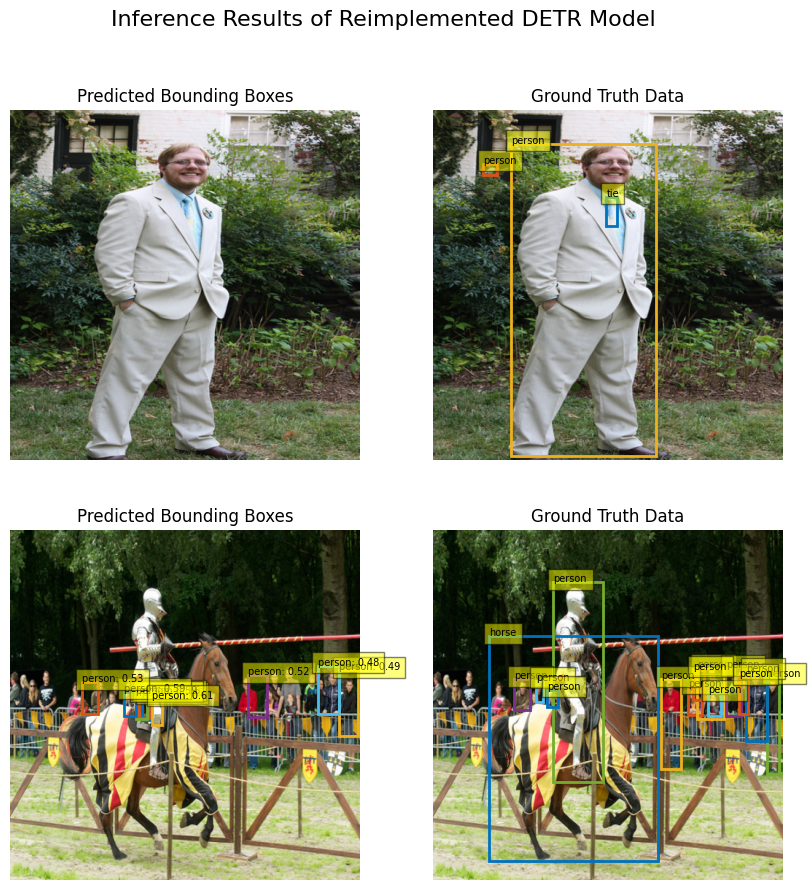

In [ ]:
# This Script can be executed independently of the one above
eval_loader = DataLoader(val_ds, batch_size=2, shuffle=True, collate_fn=collate_fn)

detr = DETR(d_model=256, n_classes=92, n_tokens=225, n_layers=6, n_heads=8, n_queries=100)
detr.cuda()

weights_path = 'check_pts/model_ep030.pt'
trained_weights = torch.load(weights_path)
detr.load_state_dict(trained_weights['state'])
detr.eval()

input_, (tgt_cl, tgt_bbox) = next(iter(eval_loader))[:2]
out_cl, out_bbox = detr(input_.cuda())['layer_5'].values()
out_bbox = out_bbox.sigmoid().cpu()
out_cl = out_cl.cpu()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
[a.set_axis_off() for a in axs.ravel()]

fig.suptitle("Inference Results of Reimplemented DETR Model", fontsize=16)
axs[0, 0].set_title("Predicted Bounding Boxes", fontsize=12)
axs[0, 1].set_title("Ground Truth Data", fontsize=12)
axs[1, 0].set_title("Predicted Bounding Boxes", fontsize=12)
axs[1, 1].set_title("Ground Truth Data", fontsize=12)

for ix in range(len(out_bbox)):
    o_cl = out_cl[ix]
    t_cl = tgt_cl[ix]
    o_bbox = out_bbox[ix]
    t_bbox = tgt_bbox[ix]

    o_probs = o_cl.softmax(dim=-1)
    o_bbox = ops.box_convert(o_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')
    t_bbox = ops.box_convert(t_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')

    im = revert_normalization(input_)[ix].permute(1,2,0).cpu().clip(0,1)

    o_keep = o_probs.argmax(-1) != 91

    axs[ix, 0].imshow(im)
    plot_im_with_boxes(im, o_bbox[o_keep], o_probs[o_keep], ax=axs[ix, 0])
    axs[ix, 1].imshow(im)
    plot_im_with_boxes(im, t_bbox, t_cl, ax=axs[ix, 1])